In [1]:
import torch, os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import repeat
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.networks.unet import UNetModel

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use only the first GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
train_dataset = MNIST("/data/edherron/data/MNIST", train=True, download=False, transform=tf)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=1
                                           )

def pad(tensor):
    return repeat(tensor, 'b -> b 1 1 1')

In [2]:
class RectifiedFlow():
    def __init__(self, model=None, device=None, num_steps=1000):
        self.device = device
        self.model = model.to(self.device)
        self.N = num_steps
        
    def get_train_tuple(self, x0=None, x1=None):
        # randomly sample timesteps for training - timesteps are analogous to 
        # points along the linear interpolation of x0 and x1.
        t = torch.rand((x0.shape[0])).to(self.device)
        
        # find interpolated x i.e., x_t
        x_t = pad(t) * x1 + (1. - pad(t)) * x0
        
        # find our ground truth target value (velocity) we want our network to
        # approximate. This velocity term is the time derivative of the linear 
        # interpolation above. ie dX_t/dt = d(t*x1 + (1-t)*x0)/dt
        velocity = x1 - x0
        
        return x_t, t, velocity
    
    def rectified_flow_loss(self, batch_of_images, x0=None):
        '''
        Loss function for rectified flow model.

        batch: is a batch of velocity images in this case MNIST digits
        
        output: loss value we will optimize params of self.model with.
        '''
        # initialize x0 and x1 and send to device
        x0 = x0.to(self.device)
        x1 = batch_of_images.to(self.device)
        
        # get inputs (x_t and t) for network and velocity value for loss function.
        xt, t, velocity = self.get_train_tuple(x0, x1)
        
        # make velocity prediction with network
        velocity_hat = self.model(xt, t)
        
        # compute loss between prediction and velocity and return
        return F.mse_loss(velocity_hat, velocity)
        
    @torch.no_grad()
    def sample_ode(self, x0=None, N=None, return_velocities=False):
        # initialize number of timesteps in ode solver
        if N is None:
            N = self.N
            
        # initialize delta t
        dt = 1./N
        # bookkeeping for images in trajectory and network preds (velocity)
        trajectory = []
        velocities = []
        
        # initialize x for solver
        x = x0.detach().clone().to(self.device)
        
        trajectory.append(x.detach().clone())
        # Euler method integration scheme
        for i in range(N):
            # init timesteps and send to device
            t = torch.ones((x0.shape[0])) * i / N
            t = t.to(self.device)
            
            #make velocity prediction
            velocity = self.model(x, t)
            
            #update x_t+1
            x = x.detach().clone() + velocity * dt
            
            trajectory.append(x.detach().clone())
            if return_velocities == True:
                velocities.append(velocity.detach().clone())
        if return_velocities == True:
            return trajectory, velocities
        return trajectory

In [6]:
def train_rectified_flow(data_loader, rectified_flow, opt):
    rectified_flow.model.train()
    running_loss = 0.0
    for data in data_loader:
        x1, _ = data
        x0 = torch.randn_like(x1)
        loss = rectified_flow.rectified_flow_loss(x1, x0)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [7]:
# Init all of our models
model = UNetModel()
model.load_state_dict(torch.load('/data/edherron/genmod/rectified_flow_weights/rf_1.pt'))
RF = RectifiedFlow(model, device)

print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in tqdm(range(2)):
    loss_rec = train_rectified_flow(train_loader, RF, opt)
    print('loss from epoch ', i, ': ', loss_rec)
    
torch.save(model.state_dict(), '/data/edherron/genmod/rectified_flow_weights/rf_1.pt')

Number of parameters:  3607873


 50%|█████     | 1/2 [00:31<00:31, 31.13s/it]

loss from epoch  0 :  0.08503996425486625


100%|██████████| 2/2 [01:01<00:00, 30.80s/it]

loss from epoch  1 :  0.08467258681008157


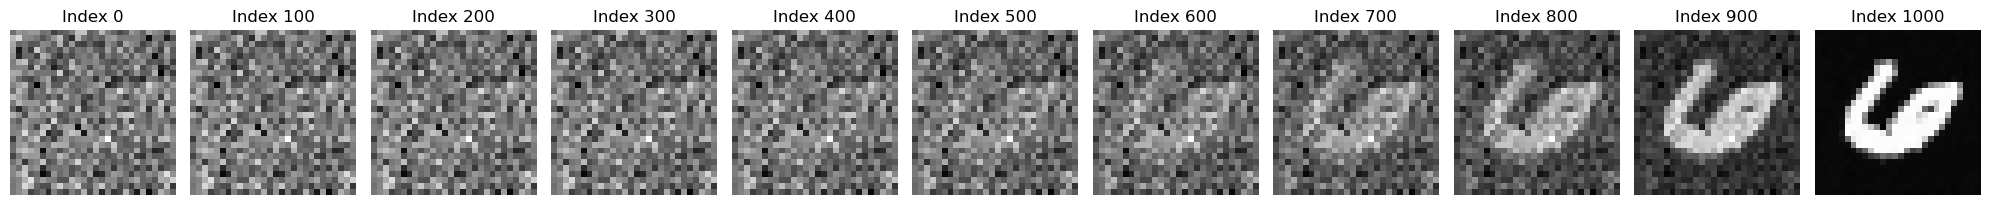

In [8]:
z = torch.randn((1,1,28,28))
trajectory = RF.sample_ode(z0 = z)

# Assuming `data_list` is your list of tensors
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for i, ax in enumerate(axs.flat):
    idx = i * 100  # Every 100th element
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Index {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()


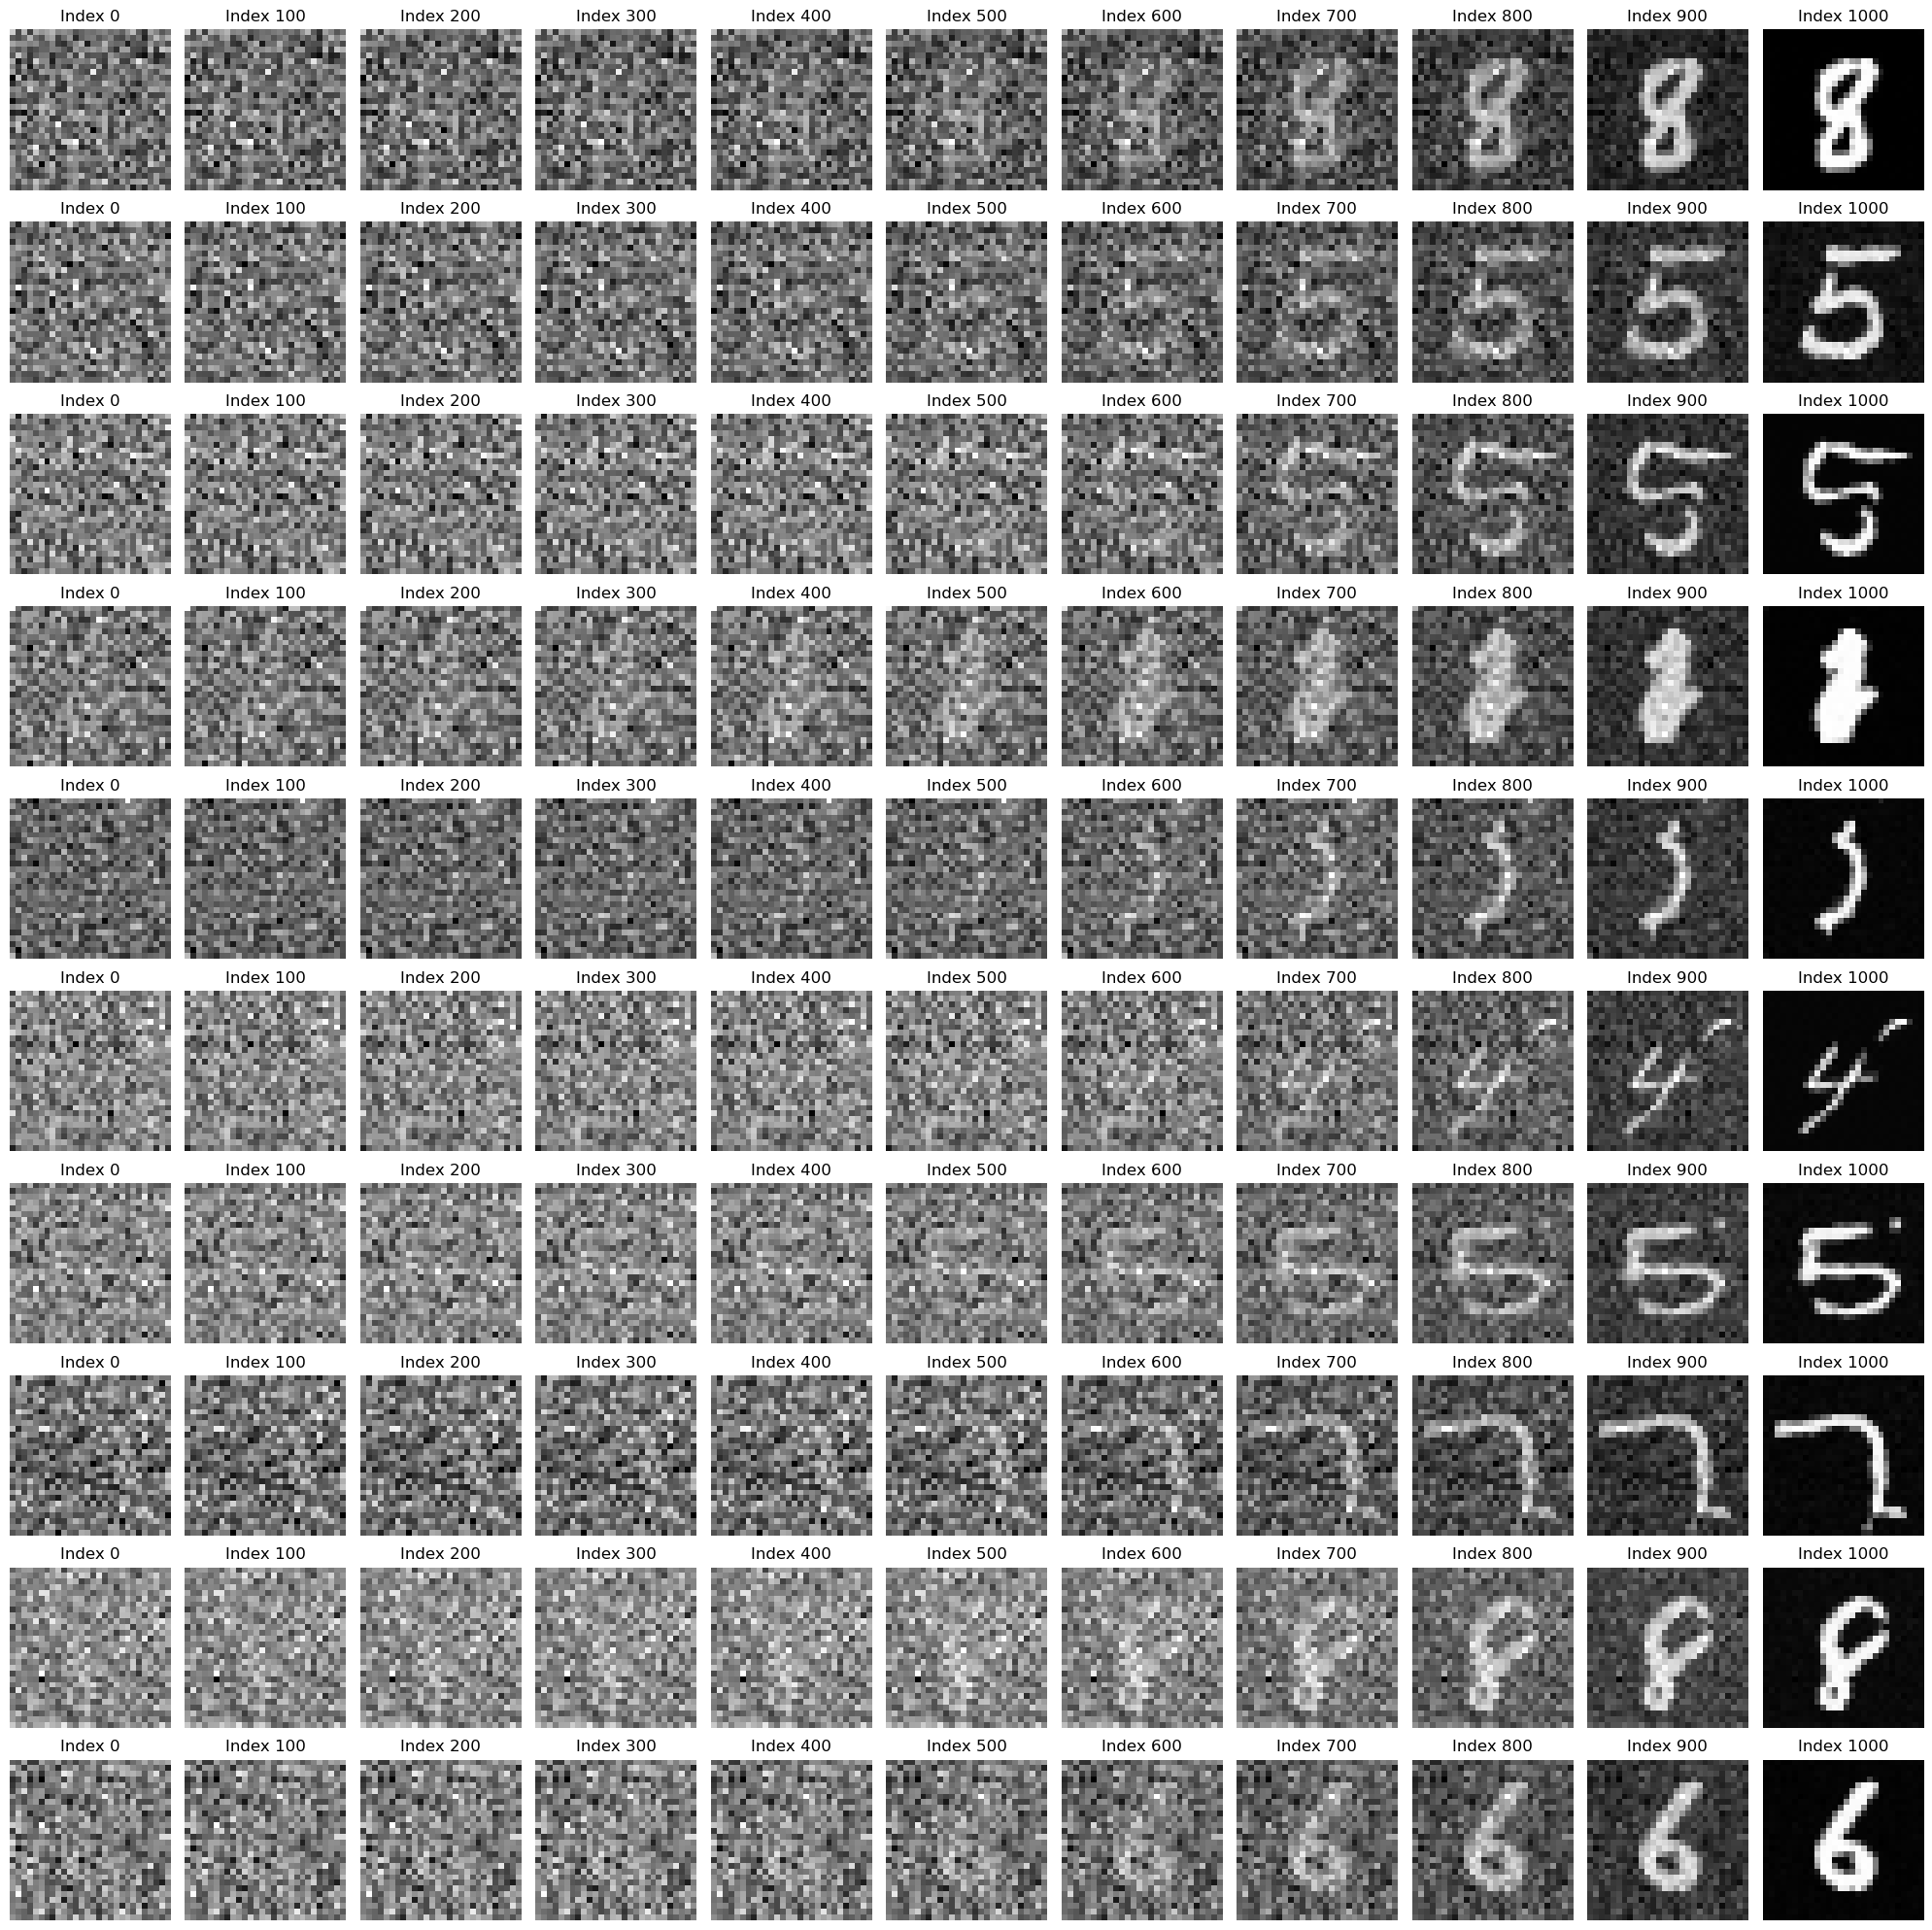

In [9]:
z = torch.randn((10, 1, 28, 28))
trajectories = [RF.sample_ode(z0=z[i].unsqueeze(0)) for i in range(10)]

# Set up the plot for 10 rows of trajectories, each with 11 time steps (same as the column convention)
fig, axs = plt.subplots(10, 11, figsize=(20, 20))  # Adjust figsize as needed, ensure there's enough space

for row, trajectory in enumerate(trajectories):
    for col, ax in enumerate(axs[row]):
        idx = col * 100  # Every 100th element as in the original convention
        if idx < len(trajectory):
            img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
            ax.imshow(img, cmap='gray')  # Plot as grayscale image
            ax.set_title(f'Index {idx}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

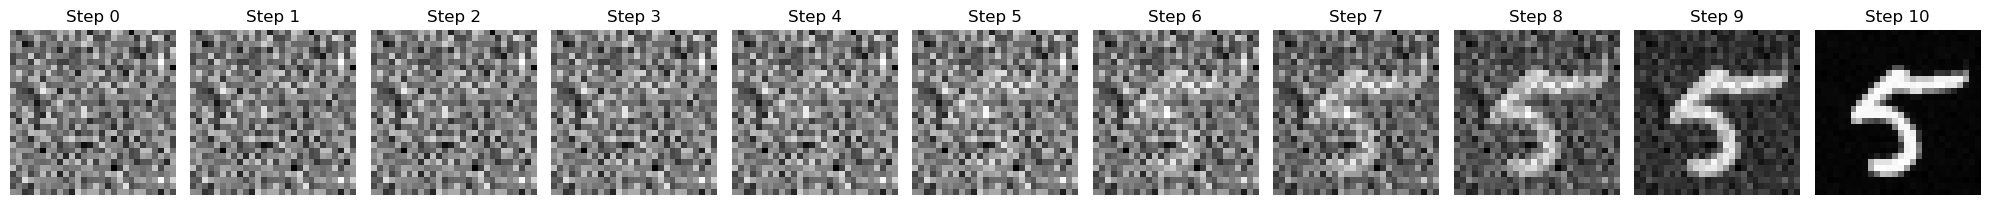

In [10]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF.sample_ode(z0 = z, N = 10)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

# Rectified Flow 2 model.
Here we take the pretrained RF model above and fine tune it on DETERMINISTIC pairs of z_0 and z_1. By randomly sampling z_0 and generating a new sample z_1 with the sampled z_0. 

In [11]:
x10 = []
x11 = []

for _ in range(100):  # The loop runs 10 times
    x = torch.randn((512, 1, 28, 28))  # Generate a new x of the specified sixe
    trajectory = RF.sample_ode(x0 = x, N = 10)  # Compute the trajectory

    # Assuming the trajectory output is a list of 11 tensors for each x in the batch
    x10.extend(trajectory[0])  # Extend x10 with the first tensors of each trajectory
    x11.extend(trajectory[-1])  # Extend x11 with the last tensors of each trajectory

# Check the lengths, should each be 10*512
print("Length of x10:", len(x10))
print("Length of x11:", len(x11))

x10_tensor = torch.stack(x10)  # Stack all tensors in x10 to create one tensor
x11_tensor = torch.stack(x11)  # Stack all tensors in x11 to create one tensor

print("x10 tensor shape:", x10_tensor.shape)
print("x11 tensor shape:", x11_tensor.shape)

x1_pairs = torch.stack([x10_tensor, x11_tensor], dim=1)
print("x1_pairs shape: ", x1_pairs.shape)

Length of z10: 51200
Length of z11: 51200
z10 tensor shape: torch.Size([51200, 1, 28, 28])
z11 tensor shape: torch.Size([51200, 1, 28, 28])
z1_pairs shape:  torch.Size([51200, 2, 1, 28, 28])


In [12]:
def train_rectified_flow_2(inner_iters, rectified_flow, opt, device):
    rectified_flow.model.train()
    running_loss = 0.0
    for _ in tqdm(range(inner_iters)):
        indices = torch.randperm(len(x10))[:256]
        batch = x1_pairs[indices]
        x0 = batch[:, 0].detach().clone()
        x1 = batch[:, 1].detach().clone()
        
        loss = rectified_flow.rectified_flow_loss(x1, x0)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(x10)
    return avg_loss

In [17]:
# Init all of our models
model_rf2 = UNetModel()
model_rf2.load_state_dict(torch.load('/data/edherron/genmod/rectified_flow_weights/rf_1.pt'))
RF_2 = RectifiedFlow(model=model_rf2, device=device, num_steps=100)
optimizer = torch.optim.Adam(RF_2.model.parameters(), lr=1e-4)

loss_rec = train_rectified_flow_2(5000, RF_2, optimizer, device)
print('loss from epoch ', i, ': ', loss_rec)

# torch.save(model_rf2.state_dict(), '/data/edherron/genmod/rectified_flow_weights/rf_2.pt')

100%|██████████| 5000/5000 [11:47<00:00,  7.07it/s]


loss from epoch  10 :  0.0007150550470714734


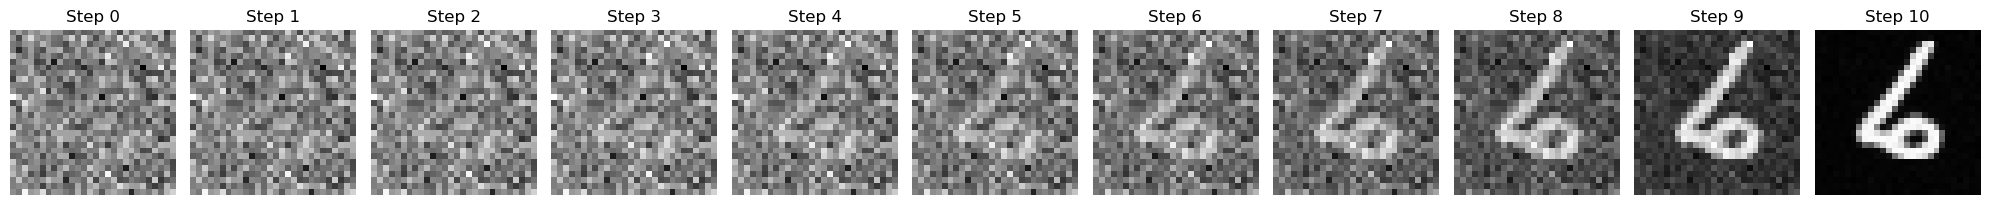

In [18]:
x0 = torch.randn((1, 1, 28, 28))
trajectory = RF_2.sample_ode(x0 = x0, N = 10)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

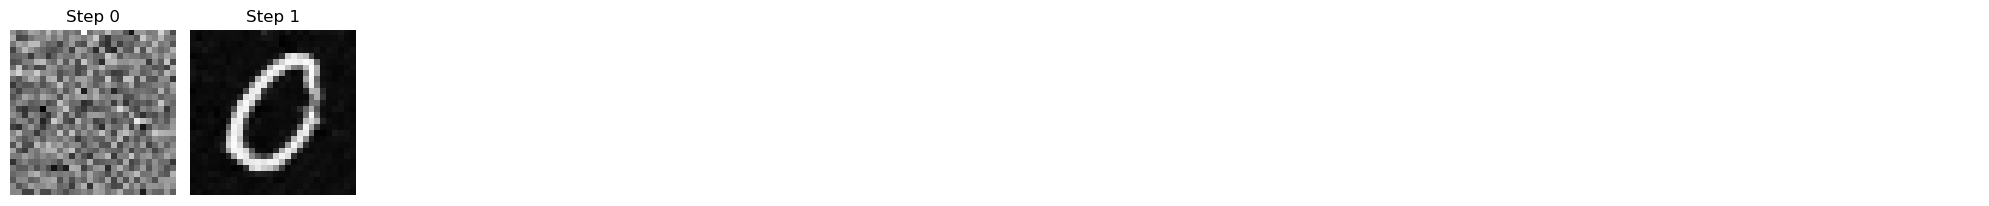

In [19]:
x = torch.randn((1, 1, 28, 28))
trajectory = RF_2.sample_ode(x0 = x, N = 1)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

In [21]:
# plot out velocities as well as trajectory
x = torch.randn((1, 1, 28, 28))
trajectory, velocities = RF_2.sample_ode(x0 = x, N = 10, return_velocities=True)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory and velocities are your lists of tensors
fig, axs = plt.subplots(2, len(trajectory), figsize=(20, 4))  # Adjust figsize as needed

for idx in range(len(trajectory)):
    # Plot trajectory tensors in the top row
    img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
    axs[0, idx].imshow(img, cmap='gray')  # Plot as grayscale image
    axs[0, idx].set_title(f'Trajectory Step {idx}')
    axs[0, idx].axis('off')
    
    # Plot velocity tensors in the bottom row
    if idx < len(velocities):
        vel_img = velocities[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        axs[1, idx].imshow(vel_img, cmap='gray')  # Plot as grayscale image
        axs[1, idx].set_title(f'Velocity Step {idx}')
        axs[1, idx].axis('off')
    else:
        axs[1, idx].axis('off')  # Hide axes for plots without corresponding velocity tensor

plt.tight_layout()
plt.show()


TypeError: sample_ode() got an unexpected keyword argument 'return_velocities'